# Decision Tree
---
**Collaborators:** Amy Zhang (lead), ChatGPT, Perplexity AI, Gemini AI  
**Date:** June 2025

---
## Overview
This notebook implements **Decision Tree** classification on daily weather records from the **OSLO weather station (1960–2022)** using six meteorological features:

- **Precipitation**  
- **Global Radiation**  
- **Sunshine Duration**  
- **Temperature Min / Mean / Max**

---

## Model Overview 🌳

Decision Trees classify data by starting with a root question and *branching* via yes/no answers, proceeding until reaching a stopping point (a *leaf*).

- Like KNN, Decision Trees **do not use gradient descent or backpropagation**, since their optimization is not based on a differentiable loss function.  
- **Unlike KNN, Decision Trees do involve a learning process:**  
  - At each node, the algorithm selects the feature and threshold that *best split* the data, using criteria such as **Gini impurity** or **information gain** (entropy).  
  - This is a *greedy* process, choosing the **locally optimal split** at every step without considering the global tree structure.  
- In contrast, KNN simply stores training data and predicts based on neighbors without optimizing model parameters.

> **Summary:**  
> - **KNN:** No parameter learning; prediction by majority vote on nearest neighbors.  
> - **Decision Tree:** Learns sequential decision rules via optimizing impurity at each node.

---

## Objectives ✅

- Preprocess OSLO weather data  
- Perform cross-validation to assess generalization and tune hyperparameters  
- Build and evaluate a Decision Tree classifier  
- Evaluate model performance using:  
  - Accuracy  
  - Confusion Matrix  
  - Tree Visualization (decision rules diagram)


# 📦 1. Import Libraries & Datasets

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data preprocessing and splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Decision Tree model and visualization
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🔒 Set seeds for reproducibility
np.random.seed(42)


In [ ]:
weather_df = pd.read_csv('Dataset-weather-prediction-dataset-processed.csv')

In [ ]:
pleasant_weather = pd.read_csv('pleasant_weather_Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

# 🧹2. Data Selection and Cleaning

- Select relevant features
- Extract X and y
- Handle missing data (drop NaNs)

*Note: Scaling is **not** performed here yet — it will be done after splitting the dataset to avoid data leakage.*

In [ ]:
# Select relevant OSLO features
oslo_features = [
    'OSLO_global_radiation',
    'OSLO_precipitation',
    'OSLO_sunshine',
    'OSLO_temp_max',
    'OSLO_temp_mean',
    'OSLO_temp_min'
]

# Extract features and target
X = weather_df[oslo_features].copy()
y = pleasant_weather['OSLO_pleasant_weather'].copy()

# Drop rows with missing values
X.dropna(inplace=True)
y = y.loc[X.index]  # Align target to cleaned features


# 📊 3. Train/Test Split
- Split data into training and testing sets
- Fit scaler on training data and transform both train and test sets

In [ ]:
# 1. Split *unscaled* data first with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### 📝 Learning Note: Decision Trees Are Scale-Invariant
Unlike KNN, SVM, or Logistic Regression, Decision Trees do not require feature scaling because:
- They are not distance-based models (like KNN or SVM),
- They are not gradient-based models (like neural nets or linear regression),
- They make decisions/splits based on ***feature thresholds***, not by calculating similarity or weights, distance or magnitude



# 🔄 4. Five-Fold Cross Validation

#### 📝 Learning Note: Why Cross-Validate for Decision Trees?

Decision Trees perform internal optimization during training, but unlike models such as Linear Regression or Neural Networks, their loss function is **not differentiable**. That means they don’t rely on gradients or iterative updates to improve performance. Instead, they use **greedy algorithms** — making locally optimal choices at each node split based on measures like **Gini impurity** or **information gain**.

This local, step-by-step decision-making process can lead to a major drawback:
Decision Trees are **high-variance models**. They are highly sensitive to the structure and distribution of the training data, which makes them prone to **overfitting** — especially when unconstrained.

To mitigate this, **cross-validation** is an important tool for:

* 🔎 Detecting overfitting patterns early
* 🔧 Tuning hyperparameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf`
* 📈 Obtaining a more robust estimate of how well the model is likely to generalize to new, unseen data

#### 🔍 Hyperparameter Tuning Insights: Decision Tree

- The grid search tested **72 different hyperparameter combinations**, using **5-fold cross-validation** for each, resulting in **360 model fits**.
- The **best parameters** found were:
  - `criterion='gini'` — splits evaluated by Gini impurity.
  - `max_depth=3` — limits the tree depth to reduce overfitting.
  - `min_samples_leaf=1` and `min_samples_split=2` — standard splitting settings.
- This means the optimal model is a **shallow tree** that balances complexity and generalization.

Next, we train the decision tree model using these optimal hyperparameters.

In [ ]:
# 2. Define a parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']  # Optional, but common to test both
}

# 3. Initialize base model
tree = DecisionTreeClassifier(random_state=42)

# 4. Set up GridSearch with cross-validation
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Parallel processing if available
    verbose=1   # Optional: shows progress in terminal
)

# 5. Fit on *training* data only
grid_search.fit(X_train, y_train)

# 6. Retrieve the best model
best_tree = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


# 🛠️ 5. Model Building and Training




In [ ]:
# 1. Extract best params from grid search
best_params = grid_search.best_params_

# 2. Initialize Decision Tree with best params
final_tree = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# 3. Fit on full training data (unscaled)
final_tree.fit(X_train, y_train)

# 4. Predict on test set
y_pred = final_tree.predict(X_test)

# 🧐 6. Evaluate

### 🧮 Final Report

The Decision Tree model achieved perfect performance on the test set: **accuracy, precision, recall, and f1-score were all 1.00**. In other words, the model is able to predict with complete confidence whether a day is classified as **pleasant** or **unpleasant** based on the given weather features.

Given that we took care to avoid data leakage, our hypothesis is that the "pleasant weather" labels were generated using simple, rule-based thresholds — making the classification task **highly deterministic and easily reverse-engineerable**. We audited the model's learned decision rules next to test this hypothesis.

Test Set Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Unpleasant       1.00      1.00      1.00      3874
    Pleasant       1.00      1.00      1.00       716

    accuracy                           1.00      4590
   macro avg       1.00      1.00      1.00      4590
weighted avg       1.00      1.00      1.00      4590



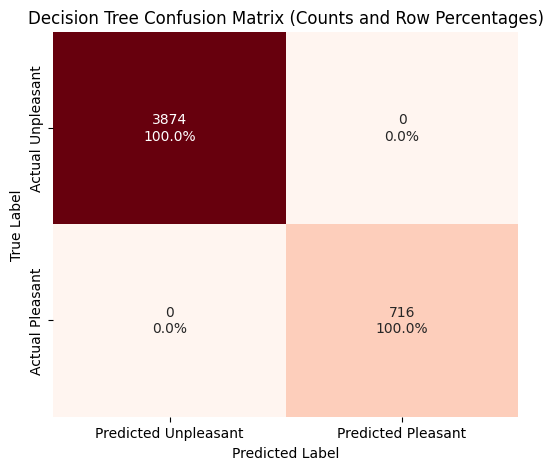

In [ ]:
# 5. Evaluate
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Unpleasant', 'Pleasant']))

# 6. Confusion Matrix Plot
# Compute raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Create annotations combining counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%"

# Plot with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Reds', cbar=False,
            xticklabels=['Predicted Unpleasant', 'Predicted Pleasant'],
            yticklabels=['Actual Unpleasant', 'Actual Pleasant'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix (Counts and Row Percentages)')
plt.show()

#### ✅ Insights from Decision Tree Audit

The resulting tree required only **three splits** to achieve perfect classification — a sign of data simplicity rather than overfitting. To validate this, we manually replicated the tree’s logic in SQL and found that applying the same rules to the original dataset also yielded a 100% match with the original labels. This confirms that the dataset was constructed in a fully separable way — likely using straightforward threshold conditions.

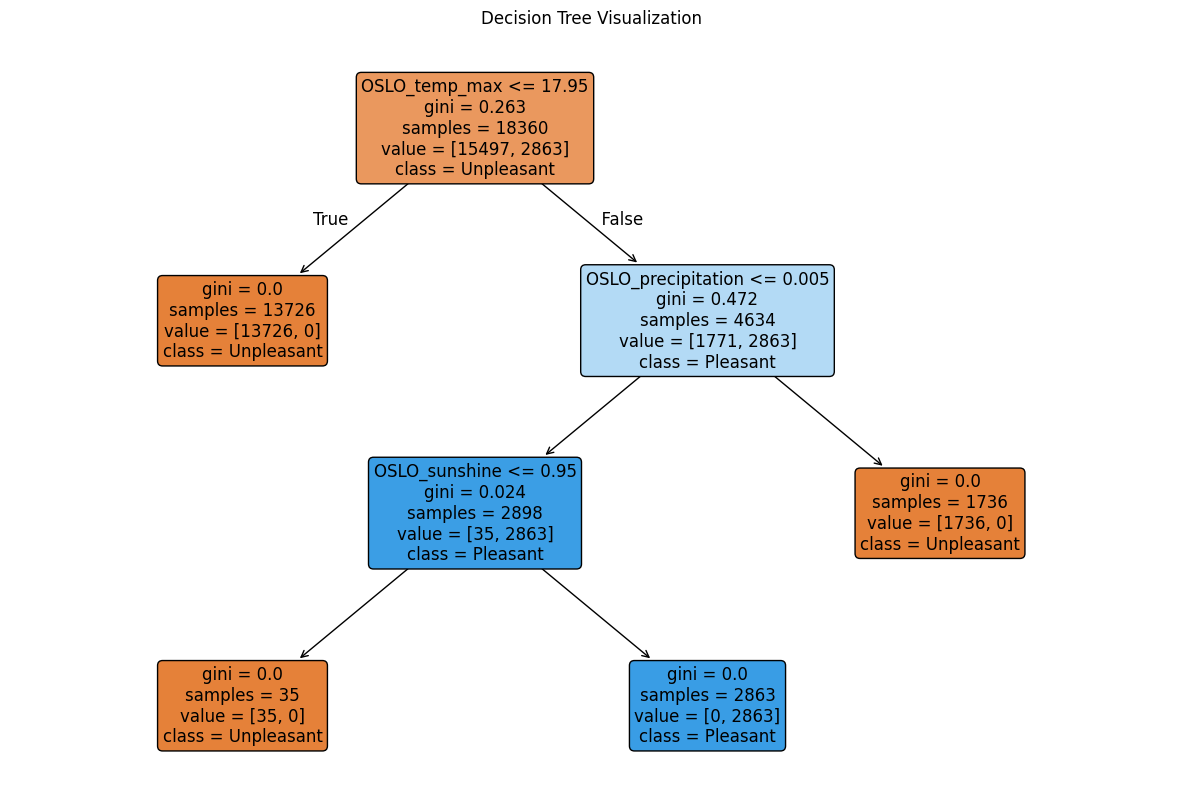

In [ ]:
# 7. Visualize the tree
plt.figure(figsize=(15,10))
plot_tree(final_tree, feature_names=X_train.columns, class_names=['Unpleasant', 'Pleasant'],
          filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
from sklearn.tree import export_text
print(export_text(final_tree, feature_names=oslo_features))


|--- OSLO_temp_max <= 17.95
|   |--- class: 0
|--- OSLO_temp_max >  17.95
|   |--- OSLO_precipitation <= 0.00
|   |   |--- OSLO_sunshine <= 0.95
|   |   |   |--- class: 0
|   |   |--- OSLO_sunshine >  0.95
|   |   |   |--- class: 1
|   |--- OSLO_precipitation >  0.00
|   |   |--- class: 0



In [ ]:
# Apply the decision rule manually
def rule_based_classifier(row):
    if row['OSLO_temp_max'] <= 17.95:
        return 0
    elif row['OSLO_precipitation'] > 0.0:
        return 0
    elif row['OSLO_sunshine'] <= 0.95:
        return 0
    else:
        return 1

X_test['rule_pred'] = X_test.apply(rule_based_classifier, axis=1)

# Compare with actual labels
(X_test['rule_pred'] == y_test).mean()  # Should give you 1.0


np.float64(1.0)

#### 📝 Learning Note: Deterministic vs. Probabilistic Classification

While supervised models are trained on labeled data, classification is **not always deterministic**. In this case, the "pleasant weather" labels appear to be generated using **clear threshold rules** on features such as temperature, sunshine hours, and precipitation. As a result, the Decision Tree was able to learn a **fully separable, rule-based decision surface**, yielding perfect accuracy with minimal splits.

However, in many real-world tasks (e.g., spam detection), label generation involves **heuristic or subjective criteria**. The boundaries between classes are often **fuzzy**, influenced by multiple weak signals, noise, and human inconsistency. In such settings, classification becomes **probabilistic**, and models learn to assign likelihoods rather than follow deterministic rules.